In [1]:
!pip install transformers datasets split-folders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import splitfolders
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
# For dislaying images
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
# Loading dataset
from datasets import load_dataset
# Transformers
from transformers import AutoImageProcessor, ConvNextV2ForImageClassification
from transformers import TrainingArguments, Trainer
# Evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
splitfolders.ratio('/content/data/', output="dataset", seed=69, ratio=(0.7, 0.2, 0.1))

Copying files: 2937 files [00:00, 5835.64 files/s]


In [ ]:
# !rm -r /content/dataset/val/.ipynb_checkpoints

In [3]:
model_name = "facebook/convnextv2-tiny-1k-224"
processor = AutoImageProcessor.from_pretrained(model_name)
model = ConvNextV2ForImageClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ConvNextV2ForImageClassification(
  (convnextv2): ConvNextV2Model(
    (embeddings): ConvNextV2Embeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextV2LayerNorm()
    )
    (encoder): ConvNextV2Encoder(
      (stages): ModuleList(
        (0): ConvNextV2Stage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextV2Layer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextV2LayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (grn): ConvNextV2GRN()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextV2Layer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
    

In [6]:
dataset = load_dataset('/content/dataset/')
dataset

Resolving data files:   0%|          | 0/2055 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/587 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/295 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2055
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 587
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 295
    })
})

In [7]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
# mu, sigma = processor.image_mean, processor.image_std #get default mu,sigma
# size = processor.size
# print(size)

# norm = Normalize(mean=mu, std=sigma) #normalize image pixels range to [-1,1]

# # resize 3x32x32 to 3x224x224 -> convert to Pytorch tensor -> normalize
# transform = Compose([
#     transforms.Resize((224, 224)),
#     ToTensor(),
#     norm
# ])

{'shortest_edge': 224}


In [ ]:
# train.set_transform(transform)
# val.set_transform(transform)
# test.set_transform(transform)

In [8]:
train[0].keys()

dict_keys(['image', 'label'])

In [9]:
def preprocess_function(examples):
    examples['pixel_values'] = [processor(images, return_tensors="pt").pixel_values[0] for images in examples['image']]
    return examples

# Apply preprocessing
train = train.map(preprocess_function, batched=True)
val = val.map(preprocess_function, batched=True)
test = test.map(preprocess_function, batched=True)

Map:   0%|          | 0/2055 [00:00<?, ? examples/s]

Map:   0%|          | 0/587 [00:00<?, ? examples/s]

Map:   0%|          | 0/295 [00:00<?, ? examples/s]

In [10]:
args = TrainingArguments(
    f"convnext-run-1",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    logging_steps=25,
)

In [11]:
# def collate_fn(examples):
#     pixels = torch.stack([example["pixel_values"] for example in examples])
#     labels = torch.tensor([example["label"] for example in examples])
#     return {"pixel_values": pixels, "labels": labels}

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='weighted')
    accuracy = accuracy_score(labels, pred)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

In [12]:
trainer = Trainer(
    model,
    args,
    train_dataset=train,
    eval_dataset=val,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [13]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.042400,1.017829,0.499148,0.432145,0.461559,0.499148
2,0.948900,0.972603,0.526405,0.469743,0.501565,0.526405
3,0.876700,0.922628,0.577513,0.545642,0.588863,0.577513
4,0.781900,0.873724,0.618399,0.593397,0.638056,0.618399
5,0.681600,0.825065,0.650767,0.629931,0.661131,0.650767
6,0.607000,0.775507,0.679727,0.666042,0.686056,0.679727
7,0.522400,0.728335,0.701874,0.690262,0.710929,0.701874
8,0.437400,0.678112,0.729131,0.720589,0.730229,0.729131
9,0.368900,0.642451,0.751278,0.740352,0.755328,0.751278
10,0.282000,0.607203,0.766610,0.761155,0.766577,0.766610


TrainOutput(global_step=1300, training_loss=0.3852141957099621, metrics={'train_runtime': 6037.4266, 'train_samples_per_second': 6.808, 'train_steps_per_second': 0.215, 'total_flos': 1.0344956748908544e+18, 'train_loss': 0.3852141957099621, 'epoch': 20.0})

In [14]:
trainer.evaluate()

{'eval_loss': 0.5578075647354126,
 'eval_accuracy': 0.7955706984667802,
 'eval_f1': 0.793484108642394,
 'eval_precision': 0.7955716957033422,
 'eval_recall': 0.7955706984667802,
 'eval_runtime': 59.1268,
 'eval_samples_per_second': 9.928,
 'eval_steps_per_second': 0.321,
 'epoch': 20.0}

In [15]:
# Evaluate the model on the test set
evaluation_metrics = trainer.evaluate(test)
print("Evaluation Metrics:")
print(evaluation_metrics)

# Get predictions on the test set
predictions = trainer.predict(test)
preds = np.argmax(predictions.predictions, axis=-1)  # Predictions for 3 classes
labels = predictions.label_ids

Evaluation Metrics:
{'eval_loss': 0.5937389135360718, 'eval_accuracy': 0.7728813559322034, 'eval_f1': 0.7690760863866799, 'eval_precision': 0.7689025851737716, 'eval_recall': 0.7728813559322034, 'eval_runtime': 30.0629, 'eval_samples_per_second': 9.813, 'eval_steps_per_second': 0.333, 'epoch': 20.0}


Confusion Matrix:


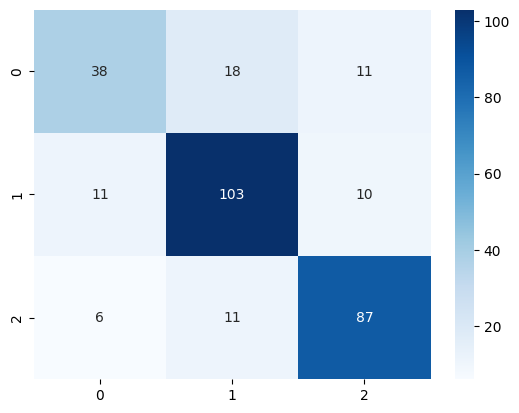


Classification Report:
              precision    recall  f1-score   support

         dry       0.69      0.57      0.62        67
      normal       0.78      0.83      0.80       124
        oily       0.81      0.84      0.82       104

    accuracy                           0.77       295
   macro avg       0.76      0.74      0.75       295
weighted avg       0.77      0.77      0.77       295



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Compute the confusion matrix for 3 classes
conf_matrix = confusion_matrix(labels, preds)

# Print the confusion matrix
print("Confusion Matrix:")
# print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()
print()

# (Optional) Get more detailed classification metrics
# Ensure `target_names` includes the names of the 3 classes
print("Classification Report:")
print(classification_report(labels, preds, target_names=test.features['label'].names))

In [17]:
trainer.save_model('ConvNeXtV2_type')

In [ ]:
from collections import Counter

# Count the number of images per class in the train set
train_labels = [example['label'] for example in dataset['test']]
train_class_distribution = Counter(train_labels)

print("Train Set Class Distribution:")
for class_id, count in train_class_distribution.items():
    print(f"Class {class_id}: {count} images")


Train Set Class Distribution:
Class 0: 40 images
Class 1: 48 images
Class 2: 15 images


In [23]:
image_path = '/content/data/normal/normal_0154cd1b2bb92b9df7f9_jpg.rf.6e50b97271bd02f4d3a82f76ef303c2d.jpg'
image = Image.open(image_path)
inputs = processor(images=image, return_tensors="pt").to(device)

# Perform inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted class index
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

# Get the labels
labels = model.config.id2label

print(f"Predicted class: {labels[predicted_class_idx]}")

Predicted class: LABEL_1
